In [4]:
import numpy as np
import pandas as pd
import os

from tvb.simulator.lab import *
import sys
import scipy.io
import tvbsim

np.random.seed(123456789)

import colorednoise as cn

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')

patient='id008_gc'
patient ='id013_pg'
# patient = 'id001_ac'

expname = 'exp007'
samplerate = 1000

metadatadir = os.path.join(root_dir, "metadata", patient)
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', expname)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

tvbsim.util.renamefiles(metadatadir)

# get the important files
getfilepath = lambda filename: os.path.join(metadatadir, filename)
seegfile = getfilepath('seeg.txt')
gainfile = getfilepath('gain_inv-square.txt')
# surffile = getfilepath

Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!


In [20]:
dist = -1
filename = os.path.join(outputdatadir, 
        patient+'_dist' + str(dist) + '_testing.npz')
npfile = open(filename, 'r')

data = np.load(npfile)
epits = data['epits']
seegts = data['seegts']
times = data['times']
zts = data['zts']
metadata = data['metadata'].item()

print(metadata.keys())
ezind = metadata['ezindices']
pzind = metadata['pzindices']
seizonsets = metadata['onsettimes']
seizoffsets = metadata['offsettimes']
region_labels = metadata['regions']

# get the onsettimes and offsettimes for ez/pz indices
allindices = np.append(ezind, pzind, axis=0).astype(int)
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.2)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes, epsilon=0)

['gainmat', 'x0norm', 'ez', 'pz', 'epiparams', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'offsettimes', 'x0pz', 'onsettimes', 'pzindices', 'patient', 'ezindices', 'chanlabels']
[14350. 22004. 22739. 26657. 30745.    nan    nan]
[21425. 31796.  8209. 31580. 35675. 27898. 14934.]


In [7]:
dt = 0.05

noiseobject = tvbsim.postprocess.noise.Noise()
noiseobject.configure_coloured(dt=dt, shape=)

TypeError: configure_coloured() takes exactly 3 arguments (1 given)

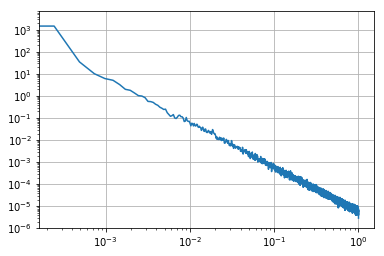

In [11]:
beta = 2 # the exponent
samples = 2**18 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, samples)

# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
#from matplotlib import pylab as plt
s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)
plt.show()

# Test Noise Within Monitor

In [21]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    '''
    @params:
    - samples        (int) the number of samples to generate
    - samplerate     (float) the samplerate of signal in Hz
    '''
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    
    return fftnoise(f)

(40000,)


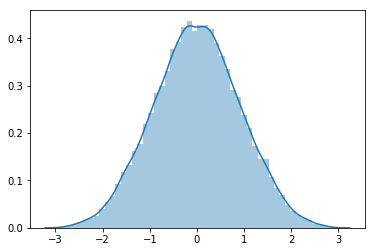

In [31]:
freqfactor = np.random.normal(1,0.01)
samplerate = 1000.
factor = 11
x = band_limited_noise(58*freqfactor, 62*freqfactor, samples=seegts.shape[1], samplerate=samplerate)
x = np.float16(x * (2**factor))
print(x.shape)

sns.distplot(x)

(59, 40000)
(59,)


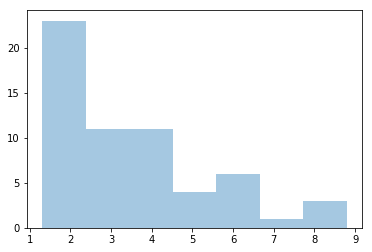

In [19]:
print(seegts.shape)
# sns.distplot(seegts.ravel(), kde=False)

avg = np.mean(np.abs(seegts), axis=1).ravel()
print(avg.shape)
sns.distplot(avg, kde=False)

In [ ]:
epsilon = 1e-3
test = seegts.copy()
factor = 9 # 9 for normal gain | -4 for simple gain
factor_2 = 5
for i in range(seegts.shape[0]): 
    freqfactor = np.random.normal(1,0.01)
    x = band_limited_noise(1*freqfactor, 62*freqfactor, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor))
    
    x = band_limited_noise(119*freqfactor, 121*freqfactor, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor))
    
    x = band_limited_noise(179*freqfactor, 181*freqfactor, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor))
    
    x = band_limited_noise(239*freqfactor, 241*freqfactor, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor_2))
    
    x = band_limited_noise(299.5, 300.5, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor_2))
    
    x = band_limited_noise(359.5, 360.5, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor_2))
    
    x = band_limited_noise(419.5, 420.5, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor_2))
    
    x = band_limited_noise(479.5, 480.5, samples=seegts.shape[1], samplerate=samplerate)
    test[i,:] = test[i,:] + np.float16(x * (2**factor_2))